# __WSI - ćwiczenie 4.__

### __Regresja i klasyfikacja__

#### __Treść ćwiczenia__

- Celem ćwiczenia jest implementacja drzew decyzyjnych tworzonych algorytmem _ID3_ z ograniczeniem maksymalnej głębokości drzewa.
- Następnie należy wykorzystać stworzony algorytm do stworzenia i zbadaniajakości klasyfikatorów dla zbioru danych breast cancer (https://archive.ics.uci.edu/ml/datasets/breast+cancer). Klasą jest poleirradiat.
- Należy pamiętać o podziale danych na zbiory trenujący, walidacyjny i testo-wy. Można użyć w tym celu gotowych funkcji.

In [795]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from seaborn import heatmap
import plotly.express as px
from math import log

RNG = np.random.default_rng()

%autoreload 

UsageError: Line magic function `%autoreload` not found.


#### __Ładowanie danych__

In [796]:

columns = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 
           'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
data = pd.read_csv('./data/breast-cancer.data', header=None, names=columns)

In [797]:
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [798]:
data.value_counts()

class                 age    menopause  tumor-size  inv-nodes  node-caps  deg-malig  breast  breast-quad  irradiat
no-recurrence-events  60-69  ge40       15-19       0-2        no         2          right   left_up      no          2
                      40-49  premeno    10-14       0-2        no         1          right   left_up      no          2
                      60-69  ge40       20-24       0-2        no         1          left    left_low     no          2
                      50-59  premeno    25-29       0-2        no         2          left    left_low     no          2
                      40-49  premeno    20-24       0-2        no         2          right   left_up      no          2
                                                                                                                     ..
                      50-59  ge40       20-24       3-5        yes        2          right   left_up      no          1
                                        25-29

In [799]:
data['irradiat'].value_counts()

no     218
yes     68
Name: irradiat, dtype: int64

In [800]:
data['node-caps'].value_counts()

no     222
yes     56
?        8
Name: node-caps, dtype: int64

#### __Usuwanie nieznanych wartości__

In [801]:
data.drop(data.loc[data['node-caps'] == '?'].index, inplace=True)

#### __Podział na zbiór trenujący i testowy__

In [802]:
RANDOM_STATE=65
PRED_LABEL = 'irradiat'
x, y = data.drop(PRED_LABEL, axis=1), data[PRED_LABEL]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

#### __Prosty model testowy__

In [803]:
class PrimitiveModel():
    def __init__(self) -> None:
        pass

    def fit(self, x, y):
        pass

    def predict(self, x):
        return ['no' for _ in range(len(x))]

In [804]:
model = PrimitiveModel()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.8214285714285714


#### __Implementacja klasyfikatora _ID3___

Istnieje kilka wariacji implementacji modułu obsługi podziału węzłów na gałęzie. Pierwszy z nich zakłada podanie zbioru wartości atrybutów wejściowych z góry, wtedy nawet jeśli w zbiorze treningowym nie ma krotek zawierających wszystkie permutacje wartości atrybutów, model stworzy odpowiednie gałęzie. Pozostaje jednak problem jak sklasyfikować powstałe w ten sposób węzły, skoro nie mamy odpowiedniej krotki. Wówczas możemy wybrać sposób podziału warunkowego, względem wybranej przez nas zasady podziału, na przykład nierówności (S1 dla x > p, S2 dla x < p dla wybranego p). Możemy też dzielić atrybuty na dwa podzbiory, pierwszy jednoelementowy zawierający tylko atrybuty o największym zysku informacyjnym i drugi zawierający wszystkie pozostałe atrybuty. Tę wariację można też zaimplementować zgodnie z drugą ideą, czyli nie podając zbioru wartości atrybutów. Zmniejsza to jednak znacznie pojemność modelu, i jego performance jest bardzo słaby.

In [805]:
class Node():
    def __init__(self, label = None, branches: dict = None, value=None, class_cardinality=0) -> None:
        self.label = label
        self.value = value
        self.branches = branches
        self.class_cardinality = class_cardinality

    def __repr__(self, level=0, path=''):
        output = "\t" * level
        if path:
            output += str(path) + ' -> '
        if self.value is not None:
            output += str(self.value)
        else:
            output += str(self.label)
        output += "\n"
        if self.branches:
            for path, node in self.branches.items():
                output += node.__repr__(level+1, path)
        return output

class ID3_v1():
    def __init__(self) -> None:
        self._root = None

    def __repr__(self):
        return self._root.__repr__()

    def fit(self, data, y_column_name):

        def split(data, target_feature):
            values = data[target_feature].unique().tolist()
            return {feature_value:data[data[target_feature] == feature_value] for feature_value in values}

        def entropy(data, y_column_name):
                return -sum([c/data.shape[0]*log(c/data.shape[0]) for c in data[y_column_name].value_counts().to_list()])
        
        def weighted_entropy(data, y_column_name, target_feature):
                return sum([subset.shape[0]/data.shape[0]*entropy(subset, y_column_name) for subset in split(data, target_feature).values()])

        def inf_gain(data, y_column_name, target_feature):
            return entropy(data, y_column_name) - weighted_entropy(data, y_column_name, target_feature)

        def recurr(data: pd.DataFrame, y_column_name: str, features: set):
            """
            overview

            Args:
                data:
                y_column_name:
                features:

            Returns:
                root

            Raises:
                None
            """

            # check end conditions

            # if all instances represent the same class,
            # return leaf with the class label
            if (data[y_column_name] == data[y_column_name].iat[0]).all():
                return Node(value=data[y_column_name].iat[0])
            # if no features are left to split on,
            # return leaf with most frequently occuring class
            if not features:
                return Node(value=data[y_column_name].value_counts().idxmax())

            # calculate information gain and choose best feature
            target_feature = max(features, key=lambda f: inf_gain(data, y_column_name, f))
            # split the branch
            data_split = split(data, target_feature).items()
            features.remove(target_feature)
            return Node(target_feature, class_cardinality=data.shape[0], branches={feature_value:recurr(branch, y_column_name, features) for feature_value, branch in data_split})

        # initiate feature set
        features = set(data.columns.tolist())
        features.remove(y_column_name)
        self._root = recurr(data, y_column_name, features)

    def feed_through(self, data_case):
        node = self._root
        while not node.value:
            value = data_case[node.label]
            # if value doesnt have a branch representing it 
            if value not in node.branches.keys():
                # choose a branch with the most cardinality
                node = max(node.branches.values(), key=lambda b: b.class_cardinality)
            else:
                node = node.branches[data_case[node.label]]
        return node.value

    def predict(self, data):
        return data.apply(self.feed_through, axis=1)

__WADA IMPLEMENTACYJNA: nazwa atrybutu nie może być 'rest'__

In [806]:
class ID3_v2():
    def __init__(self) -> None:
        self._root = None

    def __repr__(self):
        return self._root.__repr__()

    def fit(self, data, y_column_name):

        def entropy(data, y_column_name):
            return -sum([c/data.shape[0]*log(c/data.shape[0]) for c in data[y_column_name].value_counts().to_list()])
        
        def weighted_entropy(data, data_subsets, y_column_name):
            return sum([subset.shape[0]/data.shape[0]*entropy(subset, y_column_name) for subset in data_subsets])

        def inf_gain(data, data_subsets, y_column_name):
            return entropy(data, y_column_name) - weighted_entropy(data, data_subsets, y_column_name)
        
        def split(data, target_feature, target_feature_value):
            return data[data[target_feature] == target_feature_value], data[data[target_feature] != target_feature_value]
            

        def recurr(data: pd.DataFrame, y_column_name: str, features: set):
            """
            overview

            Args:
                data:
                y_column_name:
                features:

            Returns:
                root

            Raises:
                None
            """

            # check end conditions

            # if all instances represent the same class,
            # return leaf with the class label
            if (data[y_column_name] == data[y_column_name].iat[0]).all():
                return Node(value=data[y_column_name].iat[0])
            # if no features are left to split on,
            # return leaf with most frequently occuring class
            if not features:
                return Node(value=data[y_column_name].value_counts().idxmax())

            split_pairs= []
            for f in features:
                for v in data[f].unique().tolist():
                    split_pairs.append((f, v))
            # calculate information gain and choose best feature
            tmp = [(split(data, *pair), *pair) for pair in split_pairs]
            best_split, target_feature, target_feature_value = max(tmp, key=lambda t: inf_gain(data, t[0], y_column_name))
            # split the branch
            features.remove(target_feature)
            return Node(target_feature, branches={target_feature_value:recurr(best_split[0], y_column_name, features),
                                                  'rest':recurr(best_split[1], y_column_name, features)})

        # initiate feature set
        features = set(data.columns.tolist())
        features.remove(y_column_name)
        self._root = recurr(data, y_column_name, features)

    def feed_through(self, data_case):
        node = self._root
        while node.value is None:
            value = data_case[node.label]
            if value in node.branches.keys():
                node = node.branches[value]
            else:
                node = node.branches['rest']
        return node.value

    def predict(self, data):
        return data.apply(self.feed_through, axis=1)

In [807]:
tmp = pd.DataFrame(data=[['A', 1, 0],
['B', 1, 1],
['B', 2, 1],
['B', 2, 0],
['B', 3, 1]], columns=['x1','x2', 'y'])

model = ID3_v1()
model.fit(tmp, 'y')
print(repr(model))

x1
	A -> 0
	B -> x2
		1 -> 1
		2 -> 1
		3 -> 1



In [808]:
model = ID3_v1()
model.fit(train, 'irradiat')
print(repr(model))

inv-nodes
	6-8 -> tumor-size
		30-34 -> breast-quad
			left_low -> no
			right_up -> no
			right_low -> deg-malig
				2 -> yes
				3 -> no
			left_up -> no
		20-24 -> yes
		25-29 -> yes
		35-39 -> no
		40-44 -> yes
		45-49 -> no
		10-14 -> yes
	0-2 -> age
		30-39 -> breast
			right -> no
			left -> class
				recurrence-events -> node-caps
					no -> menopause
						premeno -> no
				no-recurrence-events -> no
		60-69 -> no
		50-59 -> no
		40-49 -> no
		70-79 -> no
		20-29 -> no
	3-5 -> no
	15-17 -> no
	9-11 -> yes
	24-26 -> yes
	12-14 -> yes



In [809]:
y_pred = model.predict(test)

In [810]:
def report(y_test, y_pred):
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="crest")

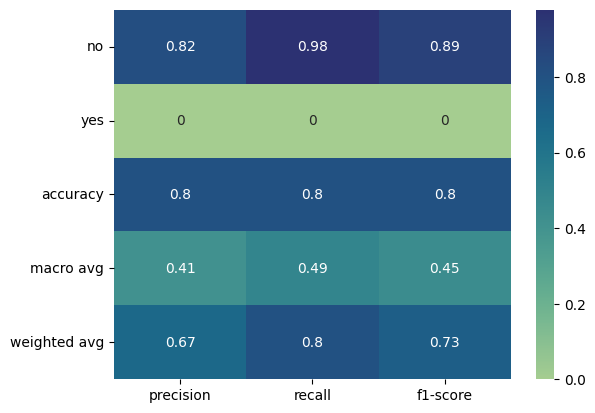

In [811]:
report(y_test, y_pred)